In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 25 days


In [2]:
import numpy as np
from matplotlib.pyplot import *

In [3]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
#matplotlib.rc('image', cmap='RdBu_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

# Generate data

In [28]:
# Generate the data that we will create knockoffs of
# it's going to be partly sinusoidal features (which are correlated)
# and partly noise features (which are uncorrelated)

n = 100
psine = 24 # number of sinusoidal features
pnoise = 1 # number of noise features
p = psine + pnoise # total number of features

randomize = False

ip = 15 # ~ number of independent sinusoidal features
noise = 0.5 # additive noise level (on top of sinusoidal features)

# Generate sinewave features
X = np.vstack([np.sin(np.linspace(0, 2*np.pi, n) * t) for t in np.linspace(1, 2*ip, psine)]).T

# Generate and include additive noise
X += np.random.randn(*X.shape) * noise

# Generate some pure noise features
X = np.hstack([X, np.random.randn(n, pnoise)])

# Amplify some rows
#X[p/2:3*p/2] *= 5
#X[3*p/2:3*p] *= 5
#X[n-p:] *= 5

# Normalize columns of X to 1
X /= np.linalg.norm(X, axis=0) 


# Generate beta & y
beta = np.sort(np.random.randn(p))
beta[np.abs(beta) < 1.0] = 0 # sparsify?

y = np.dot(X, beta)

# Find covariance between X & y, X~ & y
Xy = np.dot(X.T, y)
Xy_ko1 = np.dot(X_ko1.T, y)
Xy_ko2 = np.dot(X_ko2.T, y)

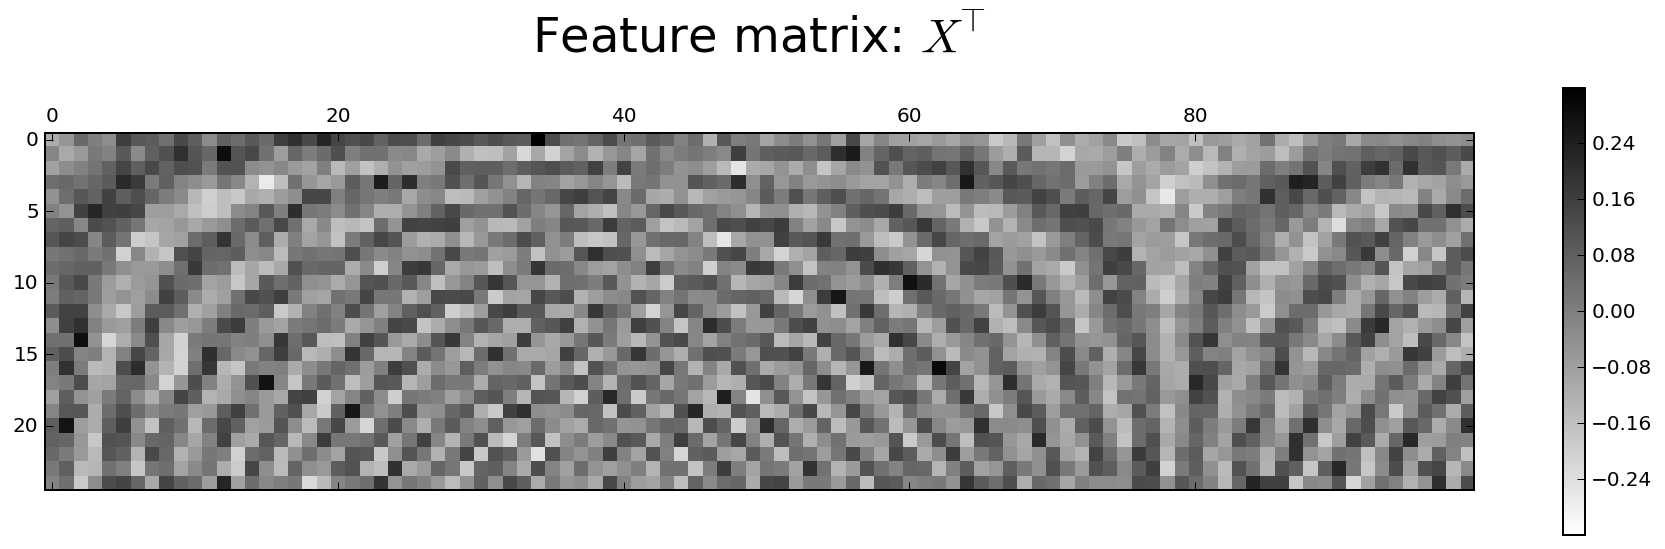

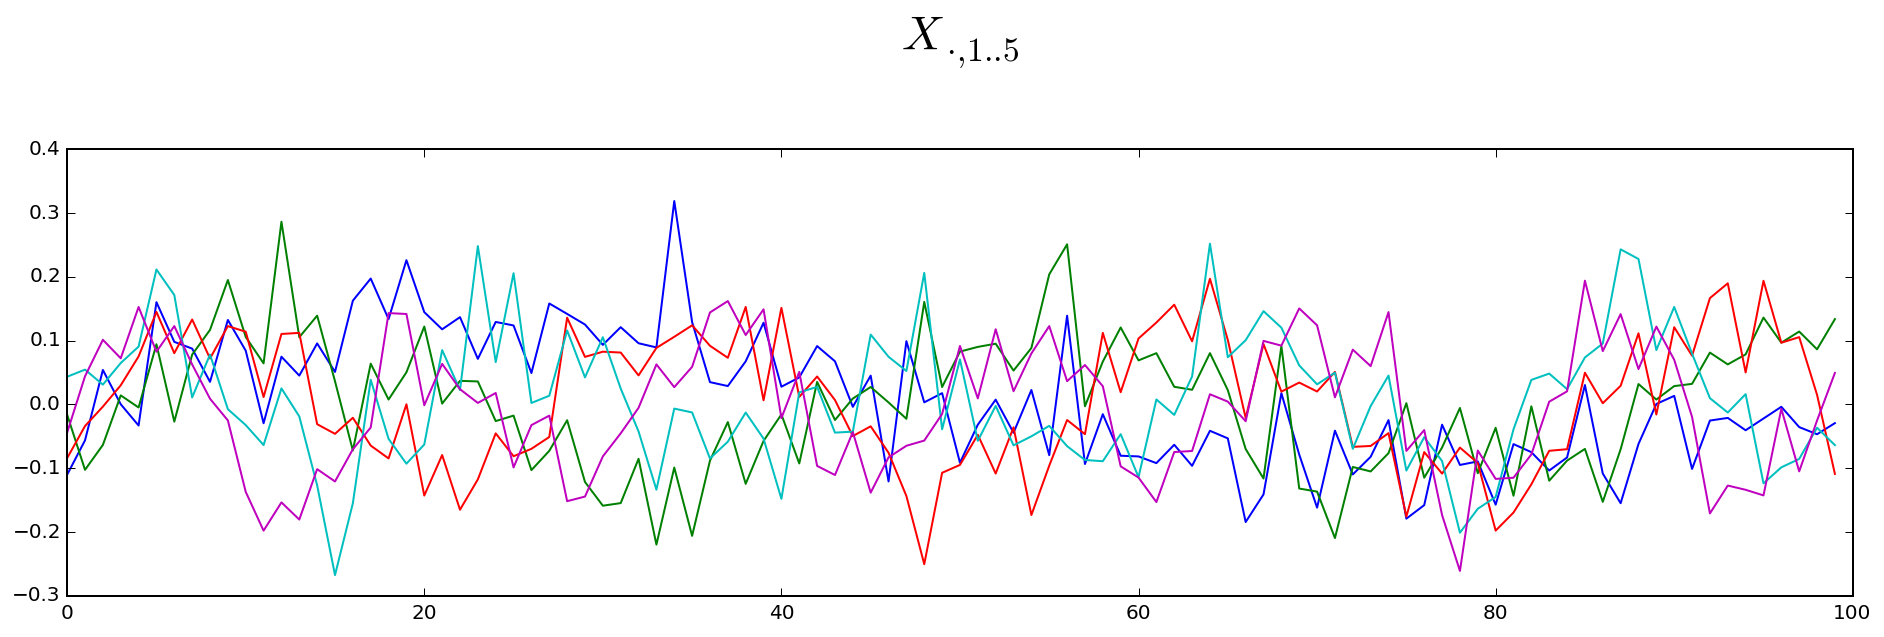

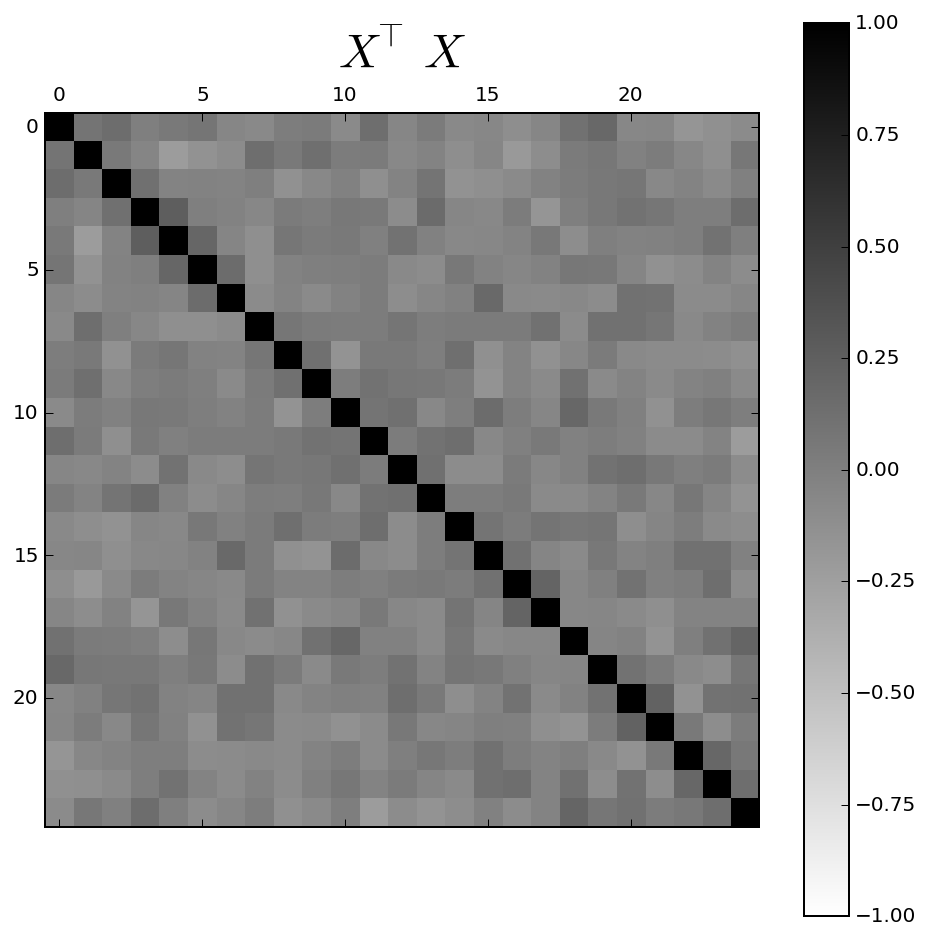

In [29]:
# Show feature matrix
matshow_symm(X.T); colorbar(); rtitle(r"Feature matrix: $X^\top$");

# Plot a few features
figure(figsize=gcf().get_size_inches()); plot(X[:,:5]); rtitle(r"$X_{\cdot,1..5}$")

matshow_symm(np.dot(X.T, X)); colorbar(); title(r"$X^\top X$");
gcf().set_size_inches(8,8)

# Equicorrelated knockoff

In [30]:
# Take SVD of X
U,S,Vh = np.linalg.svd(X, full_matrices=False)

# Create U_perp, "an orthonormal matrix whose column space is orthogonal to that of X"
# by taking "skinny" QR decomposition of U (i.e. padded w/ zeros)
# (from MATLAB code)
Q1,R1 = np.linalg.qr(np.hstack([U, np.zeros_like(X)])) # <-- method used by Barber & Candes
Q2,R2 = np.linalg.qr(np.hstack([U, np.random.randn(n,p)]))

U_perp1 = Q1[:,p:2*p]
U_perp2 = Q2[:,p:2*p]

if randomize:
    q,_ = np.linalg.qr(np.random.randn(p,p))
    U_perp = np.dot(U_perp, q)

# Confirm orthogonality, i.e. U_perp' . X = 0
print "U_perp1' . X = 0:", np.allclose(np.dot(U_perp1.T, X), 0)
print "U_perp2' . X = 0:", np.allclose(np.dot(U_perp2.T, X), 0)


# Compute s, the amount of direct cross-correlation removed
# i.e. corr( Xj, X~j ) = 1 - s
s = min(2 * S.min() ** 2, 1.0)
print "s =", s


# Compute first part of knockoff X: X . (I - Sigma^-1 . diag(s)) (2.3)
X_ko_1 = np.dot(np.dot(U, np.diag(S - s/S)), Vh)

# Second part of knockoff X: U~ . C (2.3)
X_ko_2_1 = np.dot(np.dot(U_perp1, np.diag(np.sqrt(2 * s - s ** 2 / S ** 2))), Vh)
X_ko_2_2 = np.dot(np.dot(U_perp2, np.diag(np.sqrt(2 * s - s ** 2 / S ** 2))), Vh)

# Full knockoff X (2.3)
X_ko1 = X_ko_1 + X_ko_2_1
X_ko2 = X_ko_1 + X_ko_2_2

# Confirm properties of X~
# Compute G = autocovariance and cross-covariance of X and X~ (2.1)
G1 = np.dot(np.hstack([X, X_ko1]).T, np.hstack([X, X_ko1]))
G2 = np.dot(np.hstack([X, X_ko2]).T, np.hstack([X, X_ko2]))

print "X' . X~1 = (X' . X) - diag(s): ", np.allclose(np.dot(X.T, X) - s * np.eye(p), G1[p:,:p])
print "X' . X~2 = (X' . X) - diag(s): ", np.allclose(np.dot(X.T, X) - s * np.eye(p), G2[p:,:p])

U_perp1' . X = 0: True
U_perp2' . X = 0: True
s = 0.820576972174
X' . X~1 = (X' . X) - diag(s):  True
X' . X~2 = (X' . X) - diag(s):  True


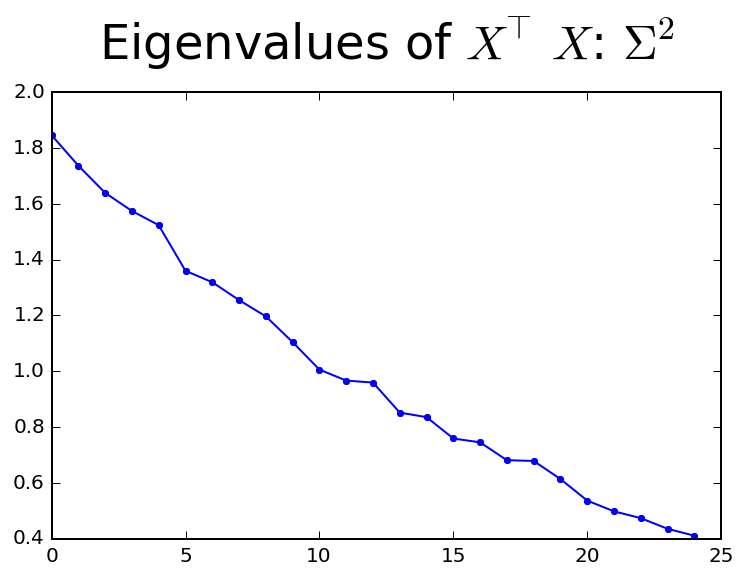

In [31]:
plot(S ** 2, '.-'); 
title(r"Eigenvalues of $X^\top X$: $\Sigma^2$", y=1.05);

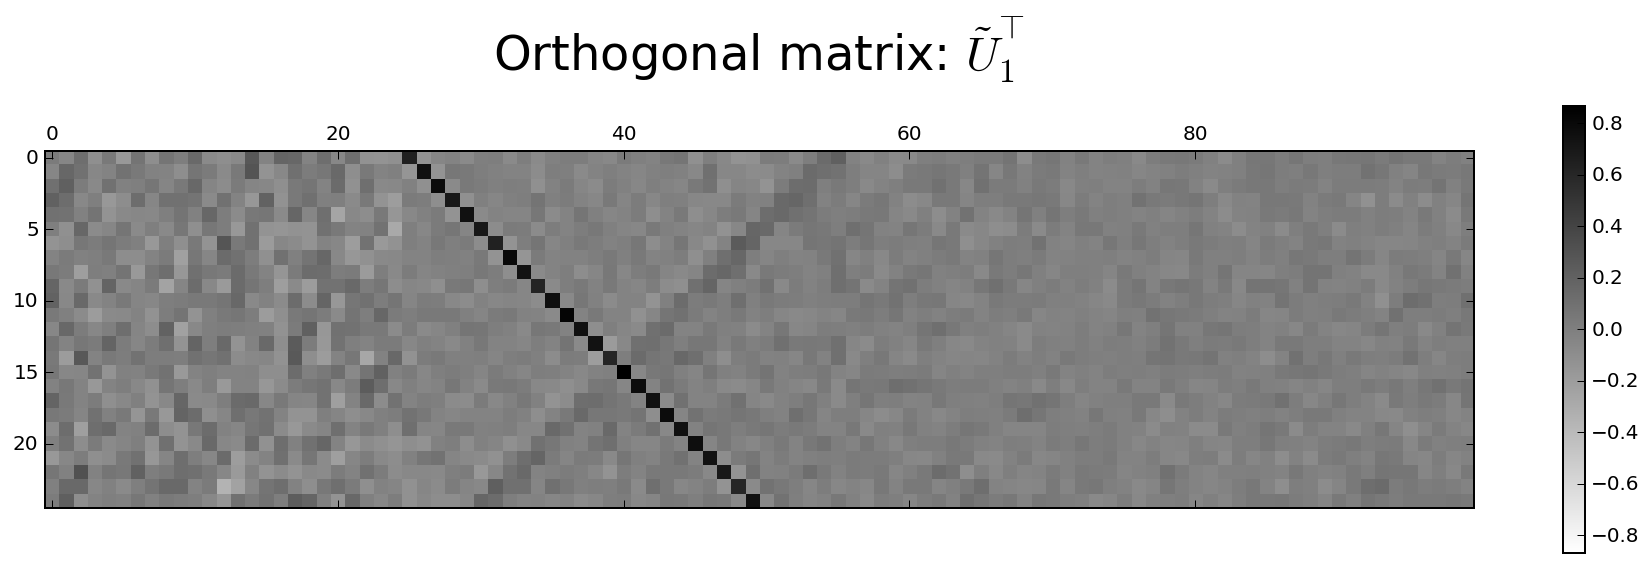

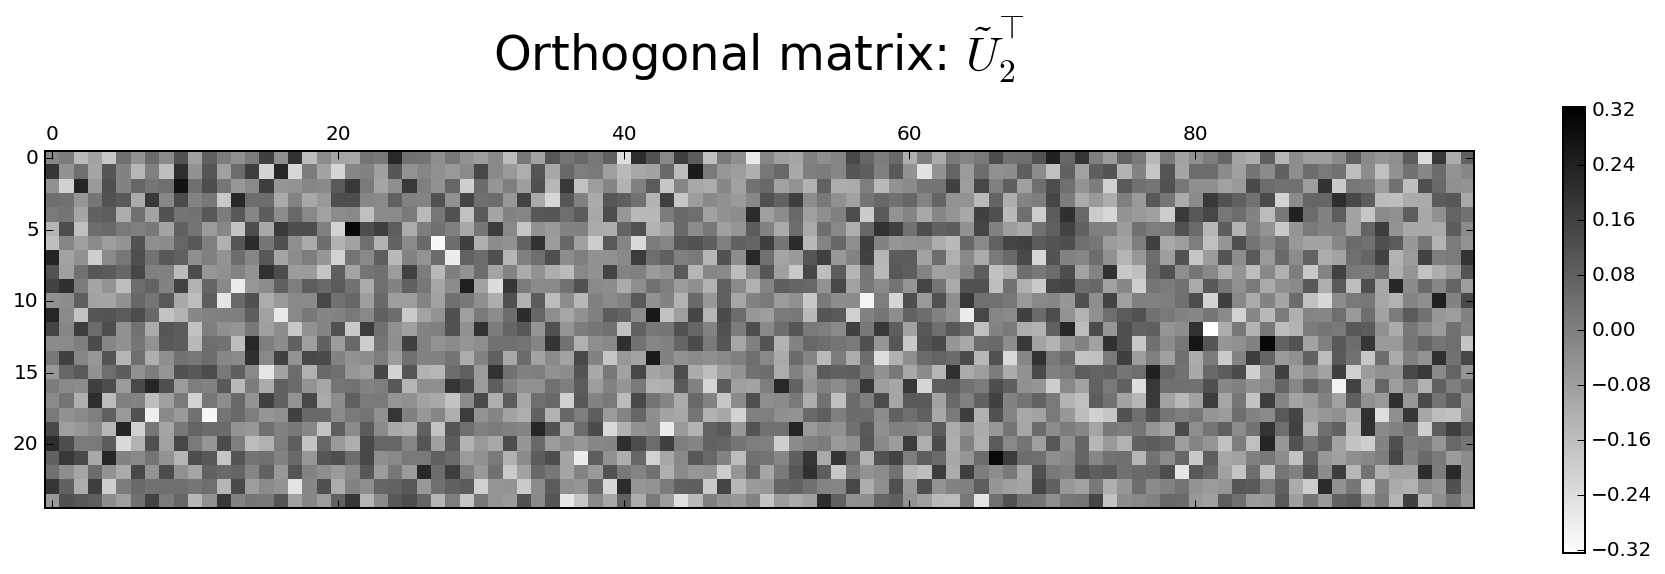

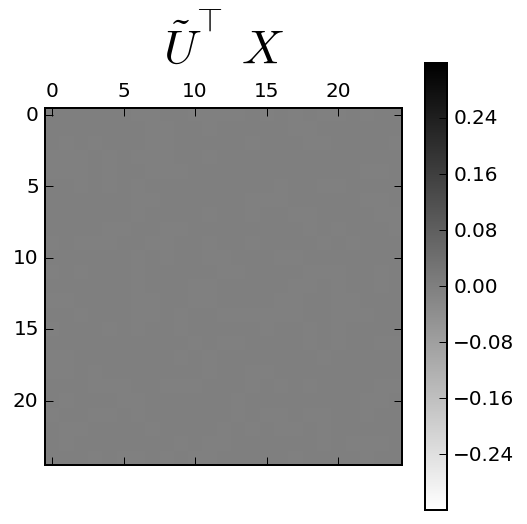

In [32]:
matshow_symm(U_perp1.T); colorbar(); 
rtitle(r"Orthogonal matrix: $\~U^\top_1$");

matshow_symm(U_perp2.T); colorbar(); 
rtitle(r"Orthogonal matrix: $\~U^\top_2$");

assert np.allclose(np.dot(U_perp1.T, X), np.dot(U_perp2.T, X))

xmax = np.abs(X).max()
matshow(np.dot(U_perp1.T, X), vmin=-xmax, vmax=xmax); colorbar(); 
title(r"$\~U^\top X$", y=1.1);

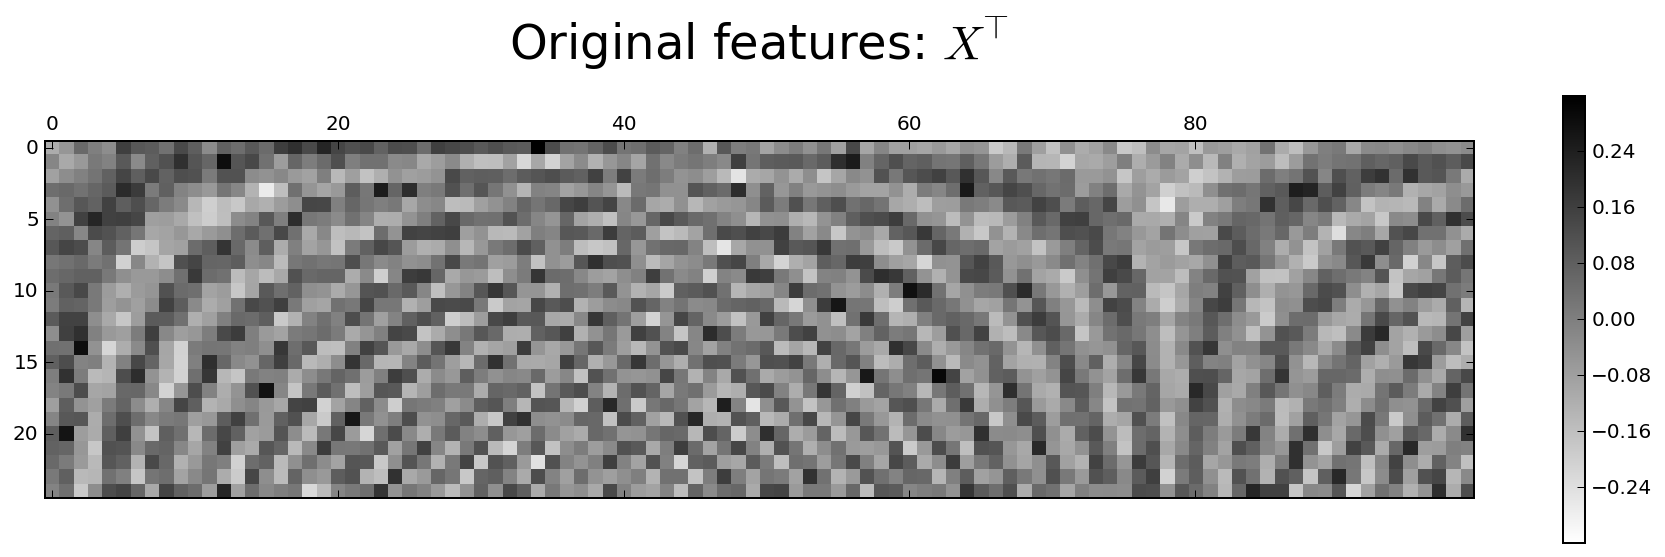

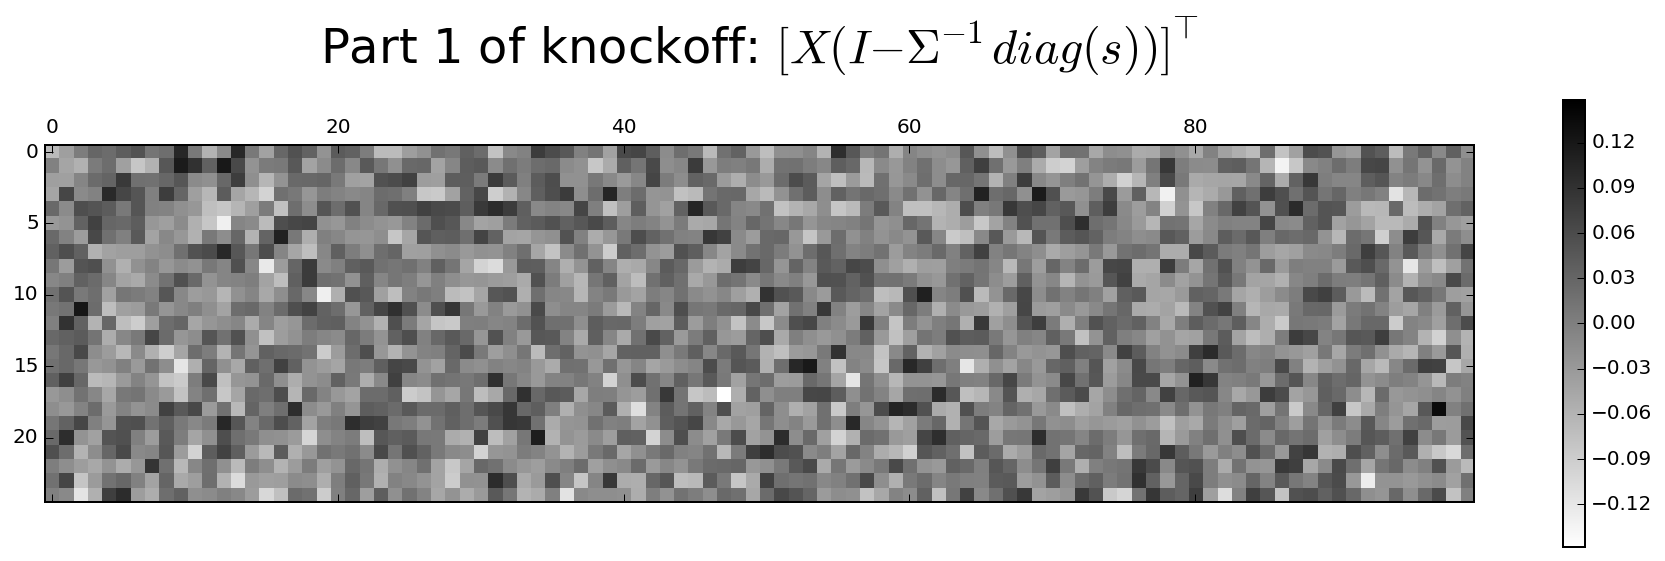

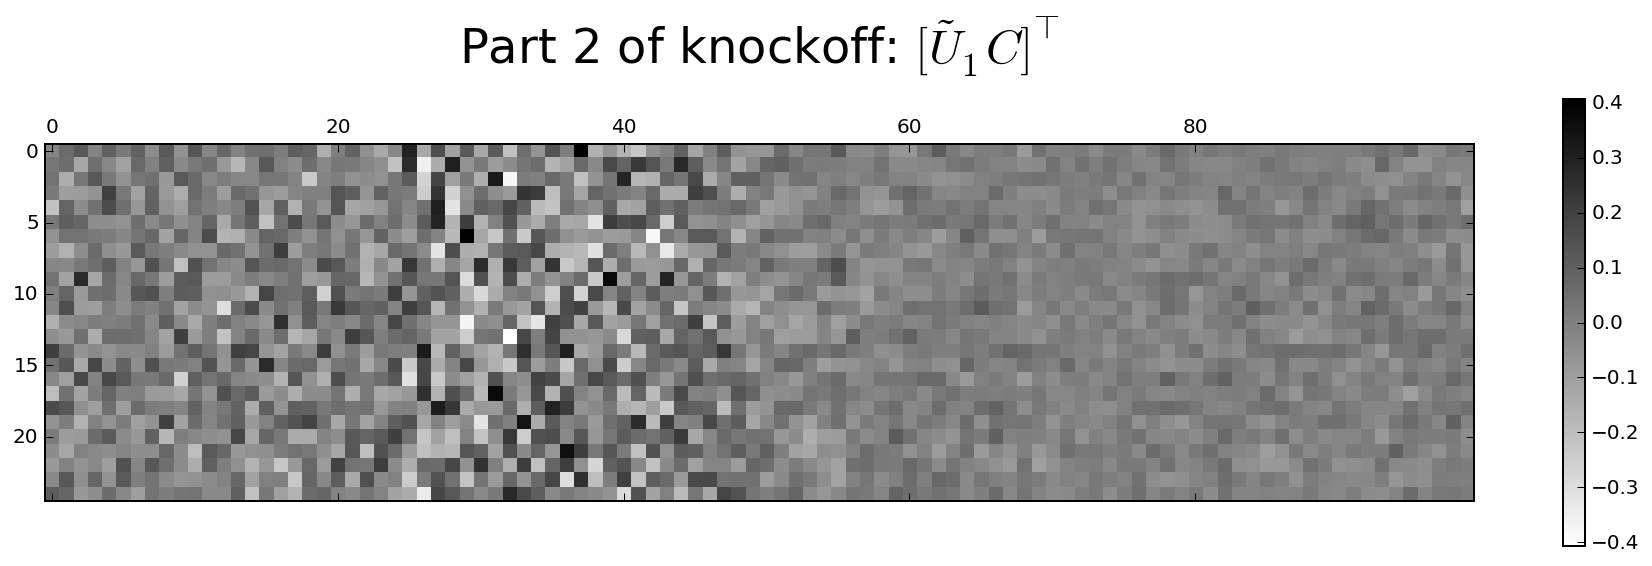

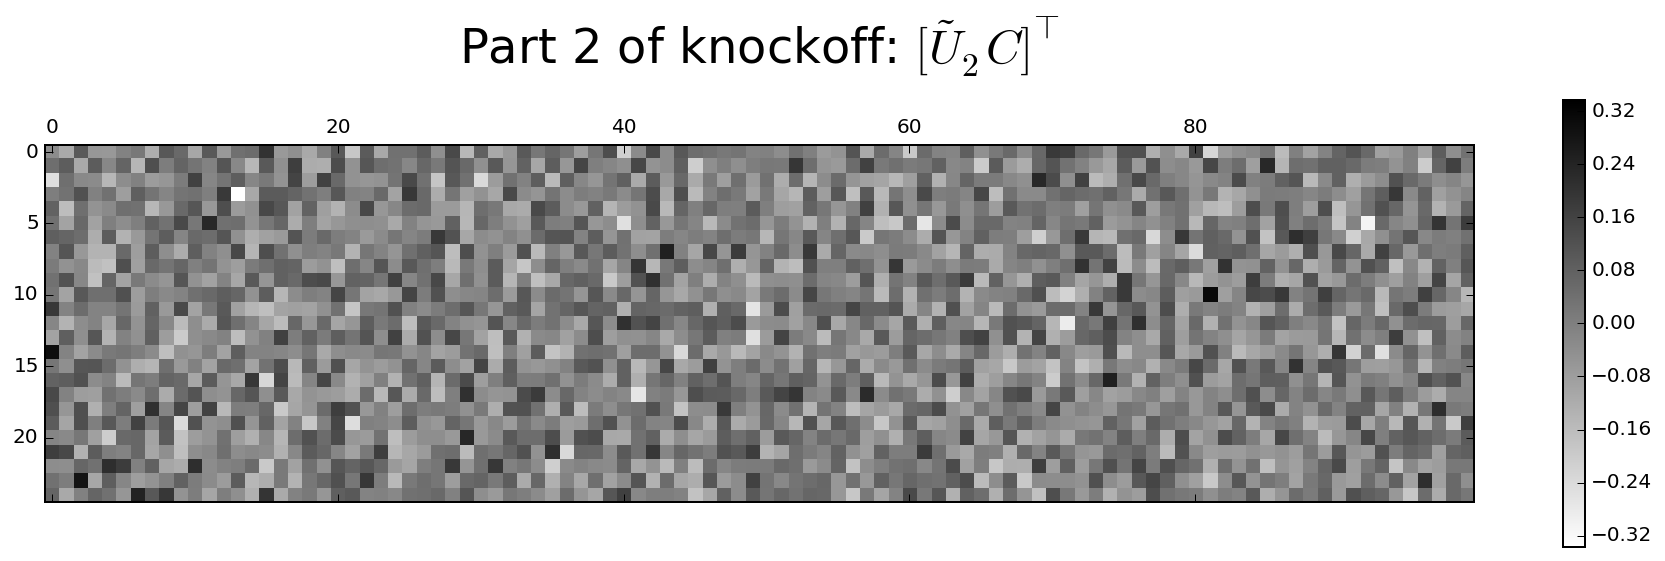

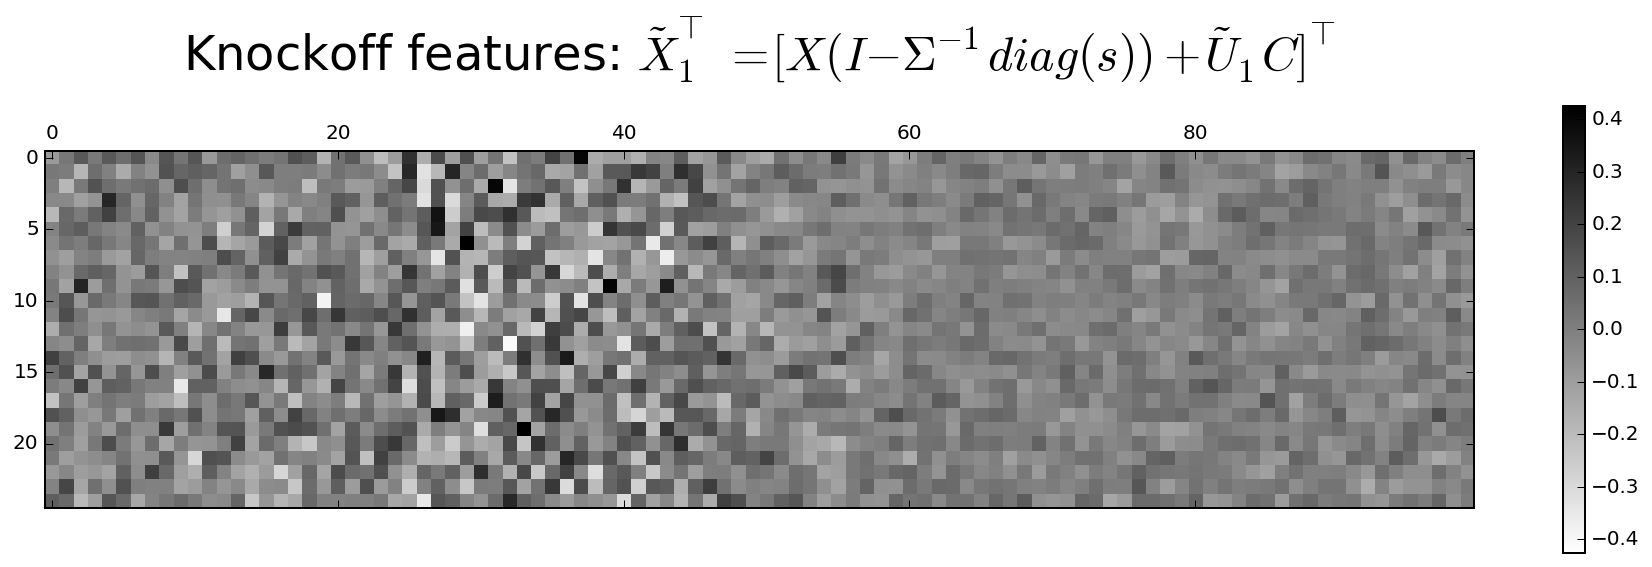

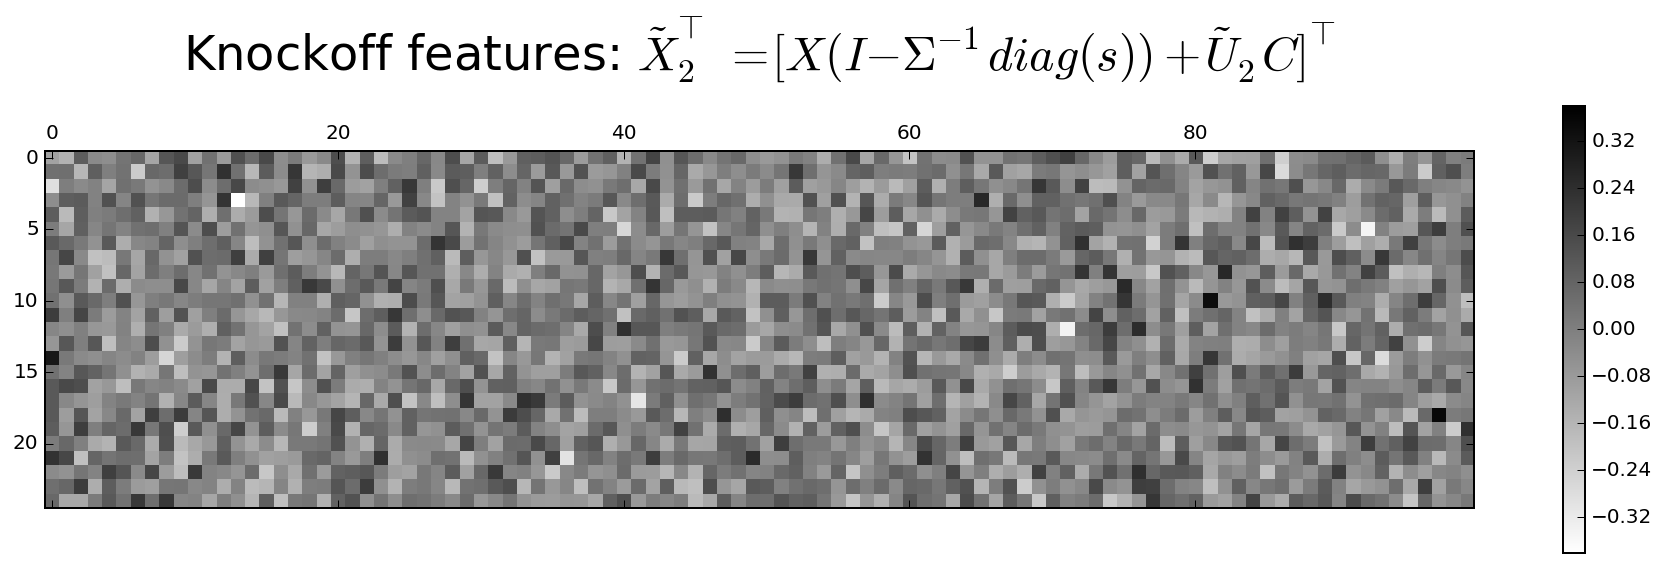

In [33]:
matshow_symm(X.T); colorbar(); 
rtitle(r"Original features: $X^\top$");

matshow_symm(X_ko_1.T); colorbar(); 
rtitle(r"Part 1 of knockoff: $[X(I - \Sigma^{-1} diag(s))]^\top$");

matshow_symm(X_ko_2_1.T); colorbar(); 
rtitle(r"Part 2 of knockoff: $[\~U_1 C]^\top$")

matshow_symm(X_ko_2_2.T); colorbar(); 
rtitle(r"Part 2 of knockoff: $[\~U_2 C]^\top$")

matshow_symm(X_ko1.T); colorbar(); 
rtitle(r"Knockoff features: $\~X^\top_1= [X(I - \Sigma^{-1} diag(s)) + \~U_1 C]^\top$");

matshow_symm(X_ko2.T); colorbar(); 
rtitle(r"Knockoff features: $\~X^\top_2= [X(I - \Sigma^{-1} diag(s)) + \~U_2 C]^\top$");

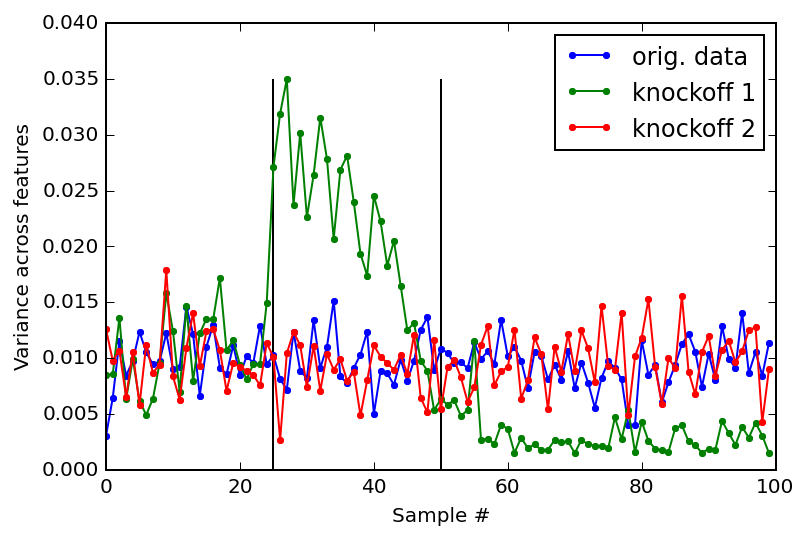

In [34]:
xline = plot(X.var(1), '.-', label="orig. data")
xkoline1 = plot(X_ko1.var(1), '.-', label="knockoff 1")
xkoline2 = plot(X_ko2.var(1), '.-', label="knockoff 2")
xlabel("Sample #"); ylabel("Variance across features")
legend(); vlines([p, 2*p], *ylim());

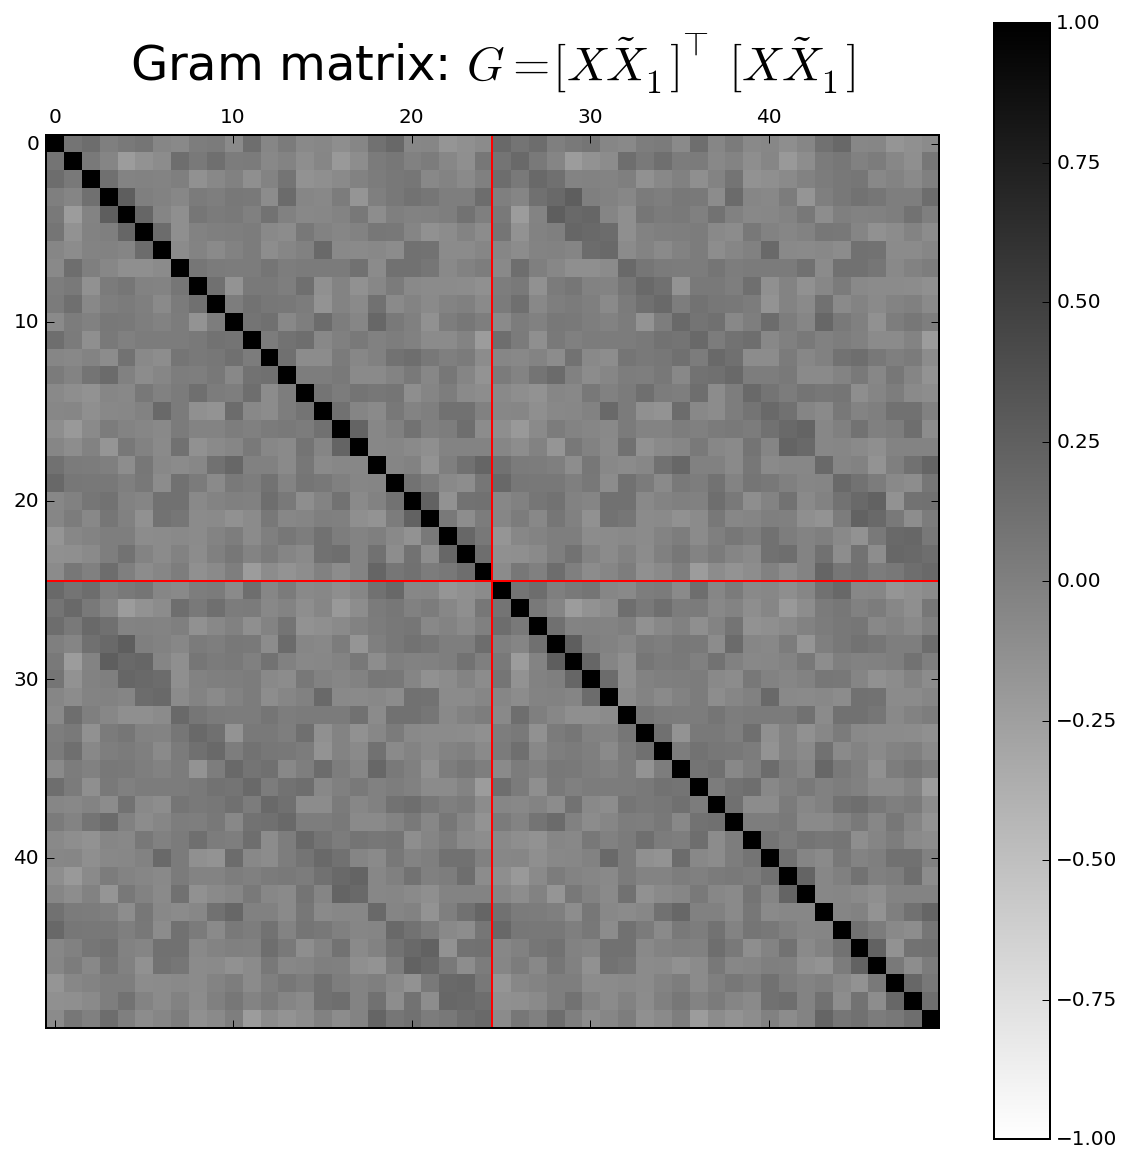

In [35]:
assert np.allclose(G1, G2)

matshow_symm(G1); colorbar(); title(r"Gram matrix: $G = [X \~X_1]^\top [X \~X_1]$")
gcf().set_size_inches(10,10)
hlines(p-0.5, -0.5, 2*p-0.5, colors='r'); vlines(p-0.5, -0.5, 2*p-0.5, colors='r');

# SDP Knockoff

In [36]:
from cvxopt import matrix, solvers

In [37]:
# Compute Gram matrix and pseudoinverse
Gram = np.dot(np.dot(Vh.T, np.diag(S ** 2)), Vh)
Gram_inv = np.dot(np.dot(Vh.T, np.diag(S ** -2)), Vh)

# Set up semidefinite program (SDP)
c = matrix(-np.ones(p)) # minimize [-1 -1 ...] . x

# -- matrix constraints: diag(x) <= 2 * Gram
h = [matrix(2 * Gram)]
g = [matrix(np.vstack([np.diag(e).reshape(1,-1) for e in np.eye(p)])).T]

# -- element-wise constraints: -x_i <= 0
h0 = matrix(np.zeros(p))
g0 = matrix(-np.eye(p)).T

# Run cvx solver
sol = solvers.sdp(c, Gl=g0, hl=h0, Gs=g, hs=h)
x = np.minimum(np.array(sol["x"]).T[0], 1.0)
print "SDP s mean:", x.mean()
print "equicorrelated s:", s

# Compute knockoff of X with new s values (i.e. x)
dix = np.diag(x)
_, D, Vh2 = np.linalg.svd(2 * dix - np.dot(np.dot(dix, Gram_inv), dix))
d = np.sqrt(np.maximum(0, D))
did = np.diag(d)

sX_ko_1 = reduce(np.dot, [X, Gram_inv, dix])
sX_ko_2_1 = reduce(np.dot, [U_perp1, did, Vh2])
sX_ko_2_2 = reduce(np.dot, [U_perp2, did, Vh2])

sX_ko1 = X - sX_ko_1 + sX_ko_2_1
sX_ko2 = X - sX_ko_1 + sX_ko_2_2

# Confirm properties of X~
# Compute G = autocovariance and cross-covariance of X and X~ (2.1)
sG1 = np.dot(np.hstack([X, sX_ko1]).T, np.hstack([X, sX_ko1]))
sG2 = np.dot(np.hstack([X, sX_ko2]).T, np.hstack([X, sX_ko2]))

assert np.allclose(sG1, sG2)

print "X' . X~ = (X' . X) - diag(s): ", np.allclose(np.dot(X.T, X) - x * np.eye(p), sG1[p:,:p])

     pcost       dcost       gap    pres   dres   k/t
 0: -2.5000e+01 -1.0000e+02  2e+02  8e-01  2e-16  1e+00
 1: -3.0288e+01 -5.2472e+01  4e+01  2e-01  2e-15  7e-01
 2: -2.6428e+01 -4.3077e+01  3e+01  2e-01  2e-15  6e-01
 3: -2.3867e+01 -2.5696e+01  3e+00  2e-02  8e-16  7e-02
 4: -2.3620e+01 -2.4255e+01  9e-01  7e-03  1e-15  2e-02
 5: -2.3508e+01 -2.3557e+01  7e-02  5e-04  6e-16  2e-03
 6: -2.3498e+01 -2.3509e+01  2e-02  1e-04  1e-15  3e-04
 7: -2.3495e+01 -2.3496e+01  1e-03  8e-06  2e-15  2e-05
 8: -2.3495e+01 -2.3495e+01  1e-04  8e-07  2e-15  2e-06
 9: -2.3495e+01 -2.3495e+01  2e-05  2e-07  2e-15  5e-07
10: -2.3495e+01 -2.3495e+01  2e-06  2e-08  7e-16  4e-08
Optimal solution found.
SDP s mean: 0.884723739935
equicorrelated s: 0.820576972174
X' . X~ = (X' . X) - diag(s):  True


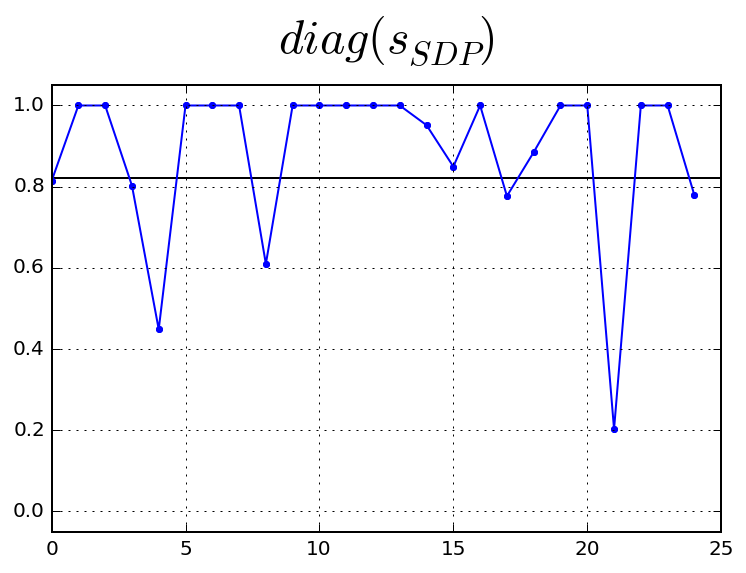

In [38]:
# x (or s_{SDP}) is how much correlation is removed for each feature channel
plot(x, '.-'); ylim(-0.05, 1.05); title("$diag(s_{SDP})$", y=1.05);

# this is how much was removed for all channels in equicorrelated case
hlines(s, 0, p);
grid();

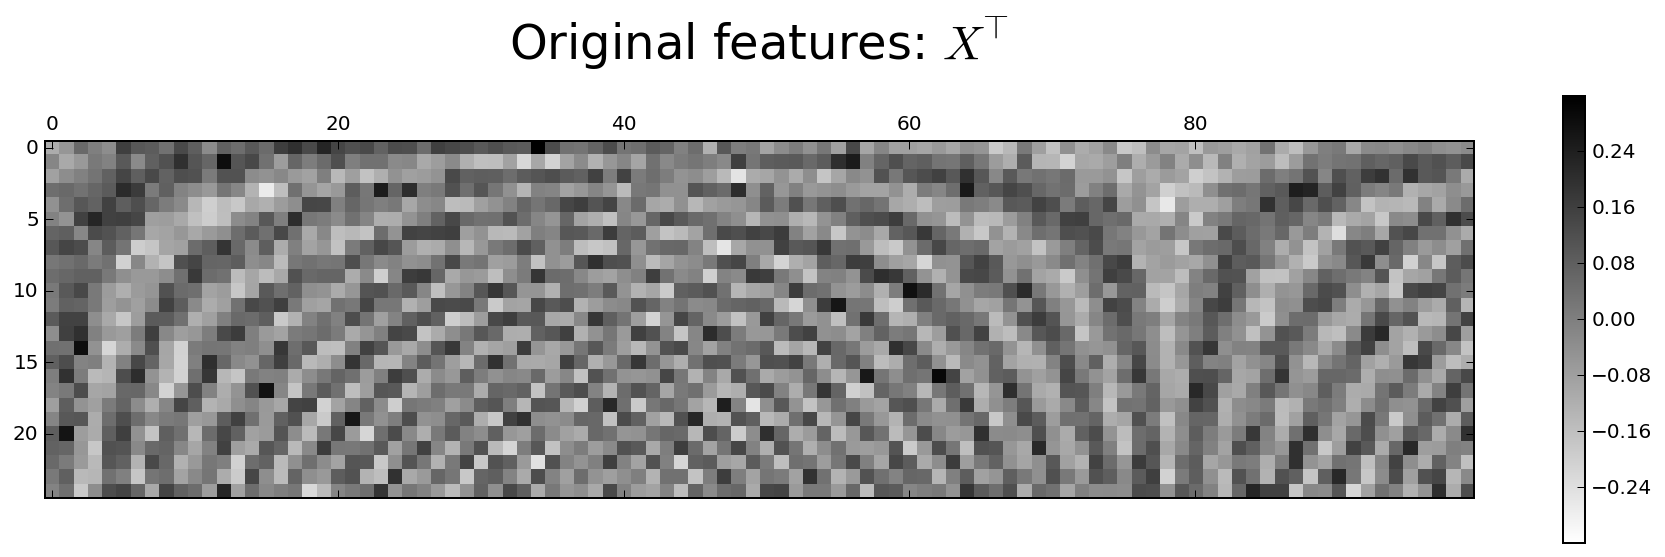

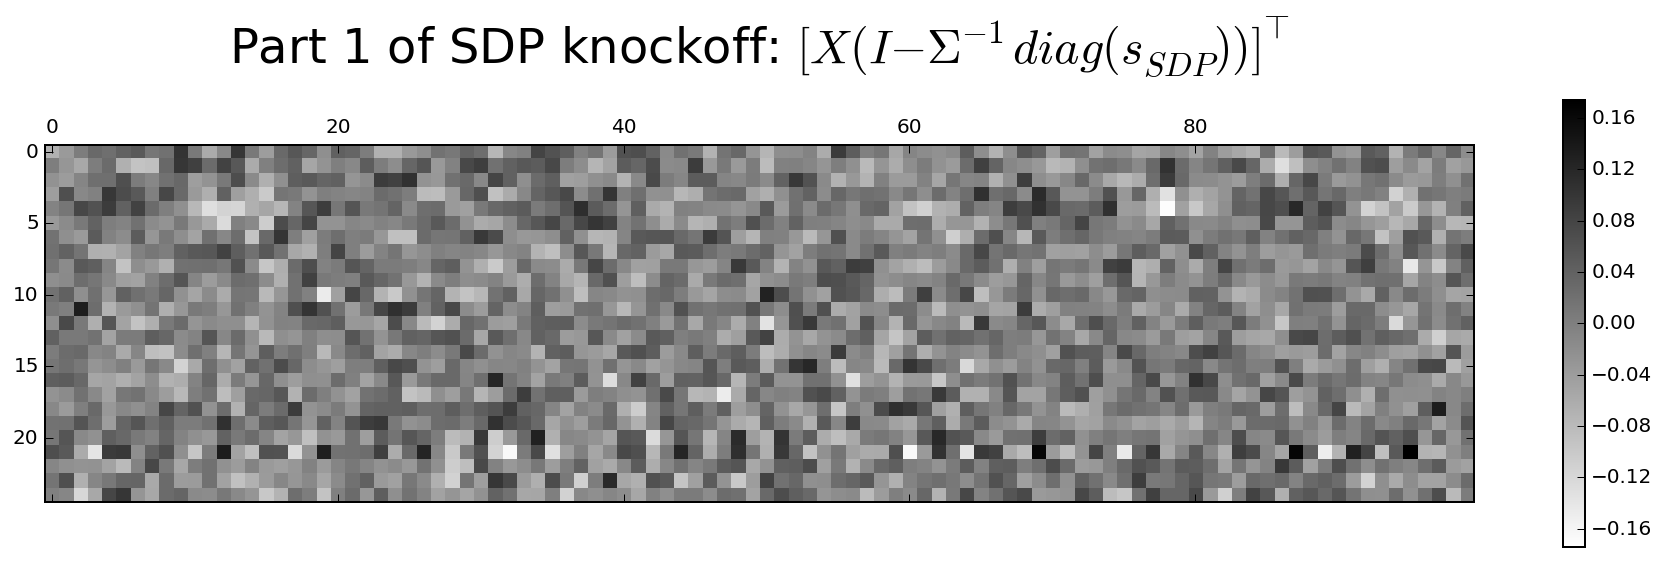

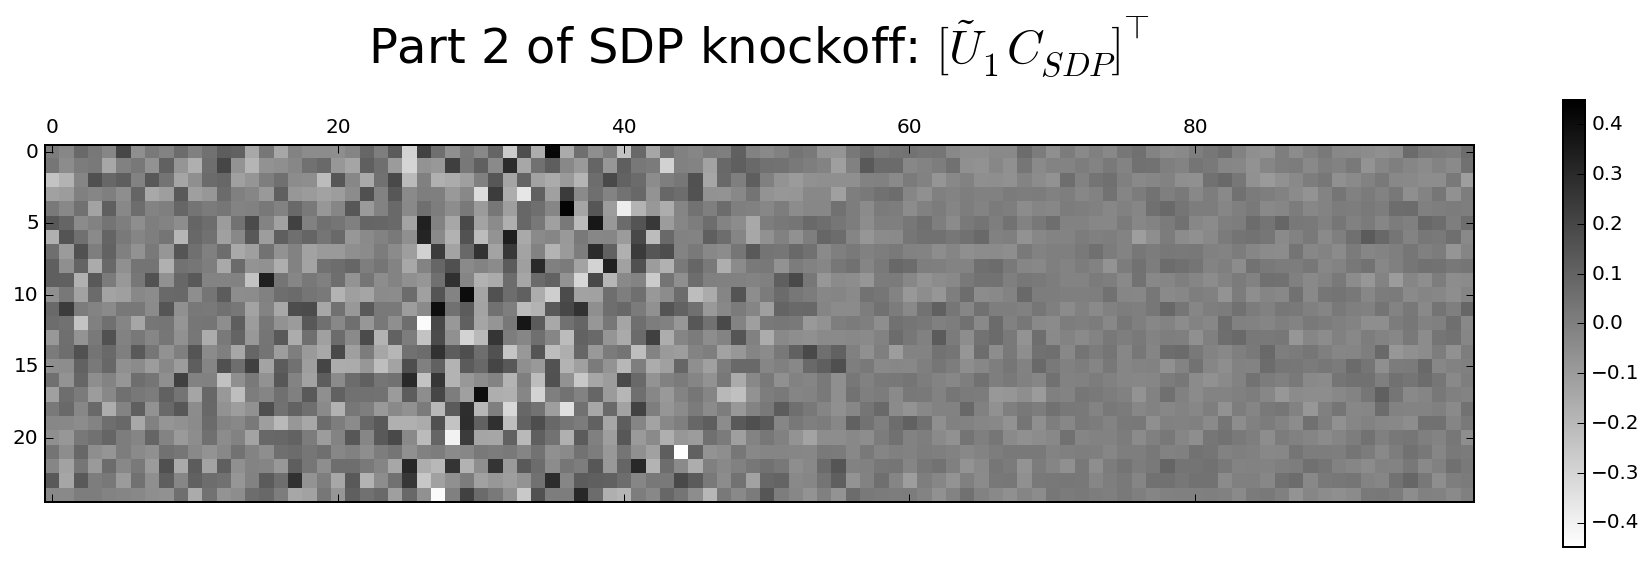

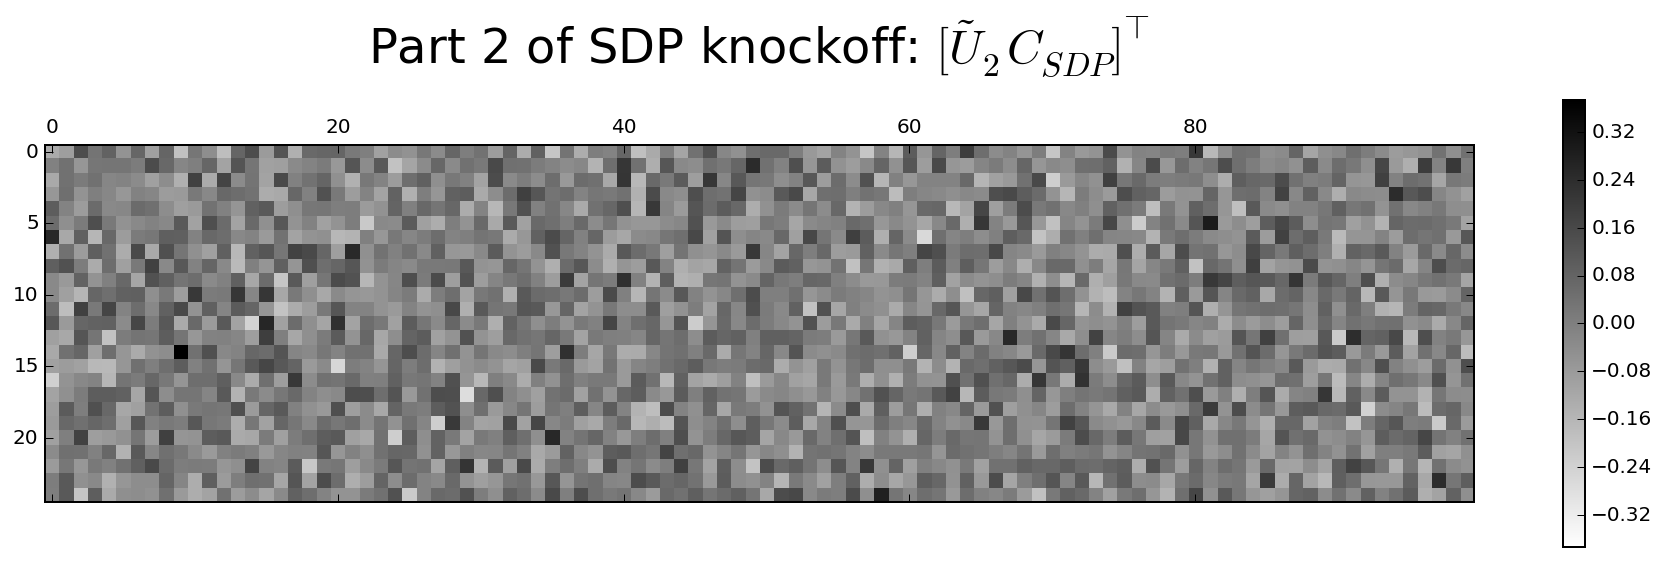

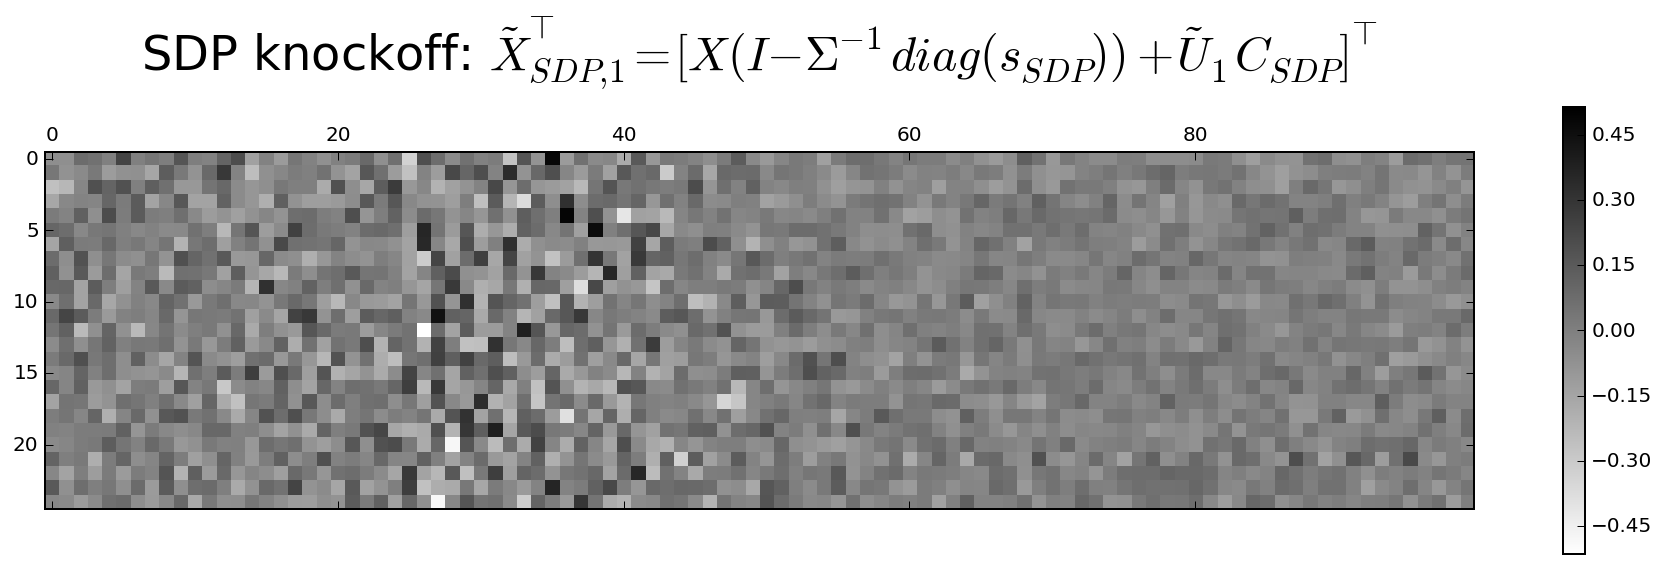

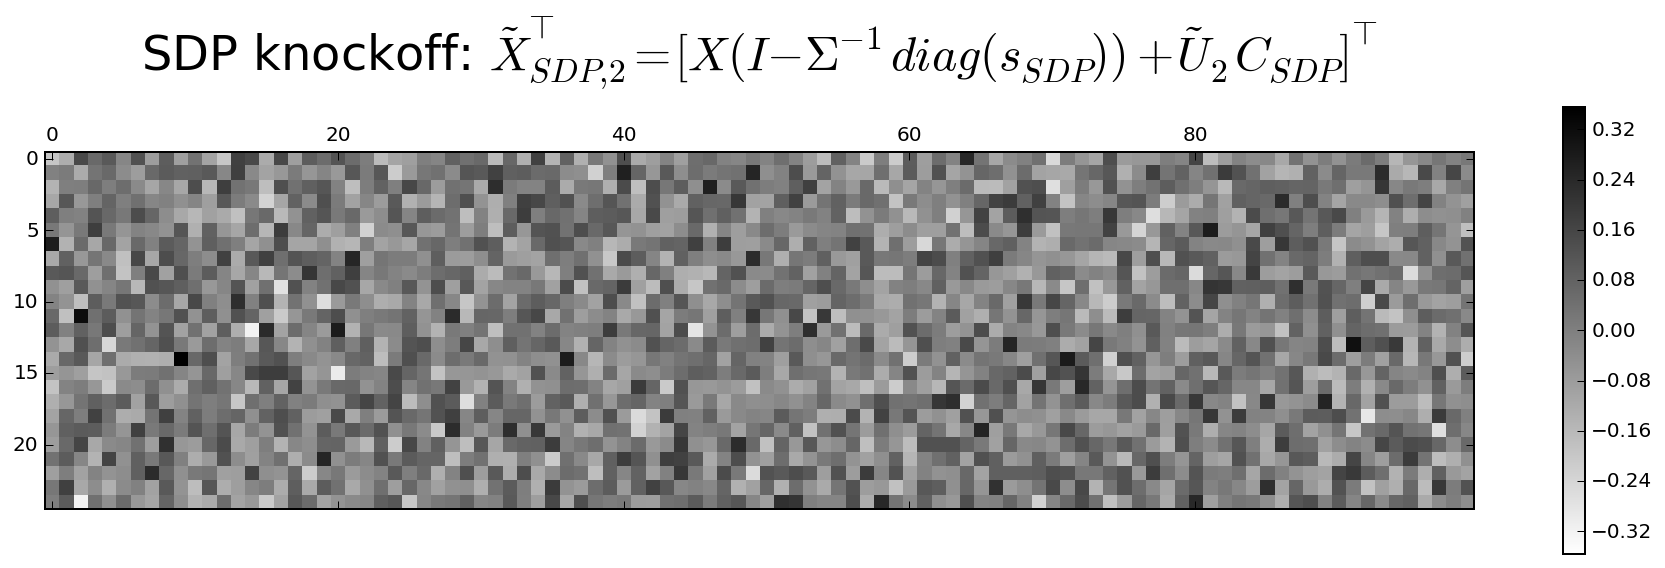

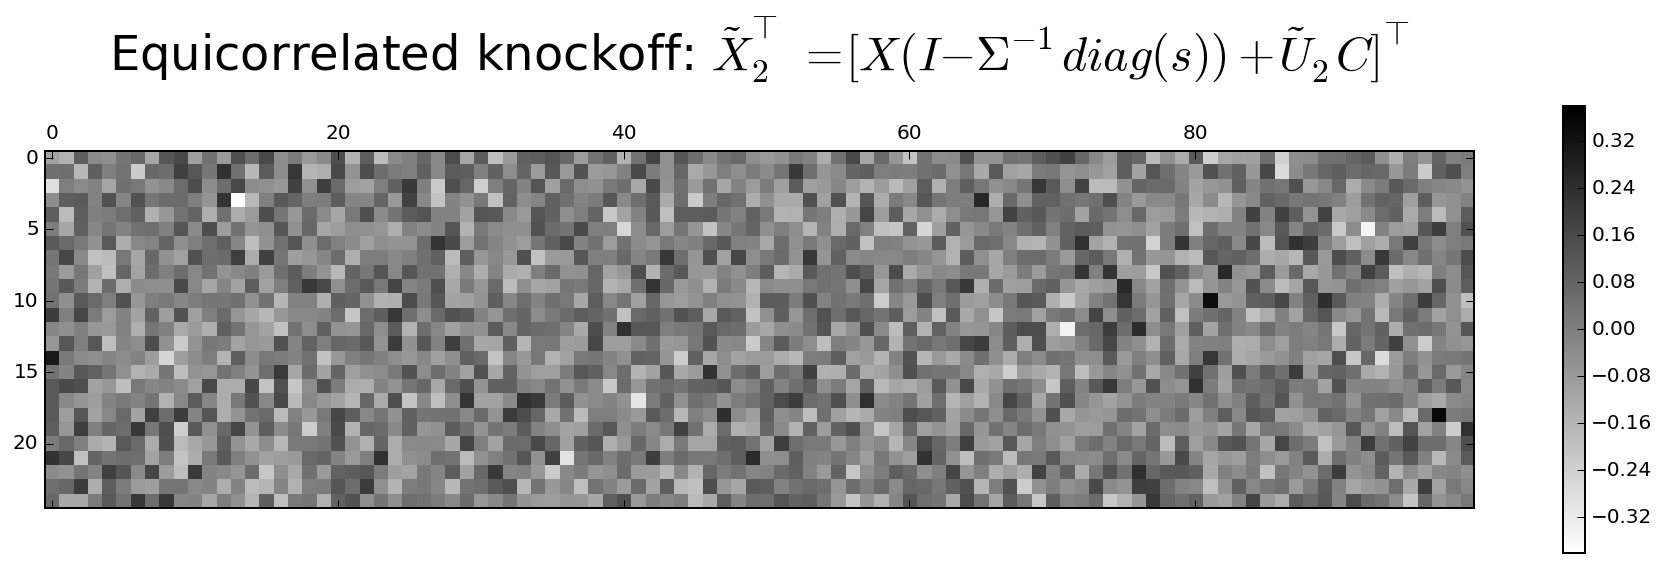

In [39]:
matshow_symm(X.T); colorbar(); rtitle(r"Original features: $X^\top$")

matshow_symm(X.T - sX_ko_1.T); colorbar(); 
rtitle(r"Part 1 of SDP knockoff: $[X(I - \Sigma^{-1} diag(s_{SDP}))]^\top$");

matshow_symm(sX_ko_2_1.T); colorbar(); 
rtitle(r"Part 2 of SDP knockoff: $[\~U_1 C_{SDP}]^\top$")

matshow_symm(sX_ko_2_2.T); colorbar(); 
rtitle(r"Part 2 of SDP knockoff: $[\~U_2 C_{SDP}]^\top$")

matshow_symm(sX_ko1.T); colorbar()
rtitle(r"SDP knockoff: $\~X^\top_{SDP,1} = [X(I - \Sigma^{-1} diag(s_{SDP})) + \~U_1 C_{SDP}]^\top$");

matshow_symm(sX_ko2.T); colorbar()
rtitle(r"SDP knockoff: $\~X^\top_{SDP,2} = [X(I - \Sigma^{-1} diag(s_{SDP})) + \~U_2 C_{SDP}]^\top$");

matshow_symm(X_ko2.T); colorbar(); 
rtitle(r"Equicorrelated knockoff: $\~X^\top_2 = [X(I - \Sigma^{-1} diag(s)) + \~U_2 C]^\top$");

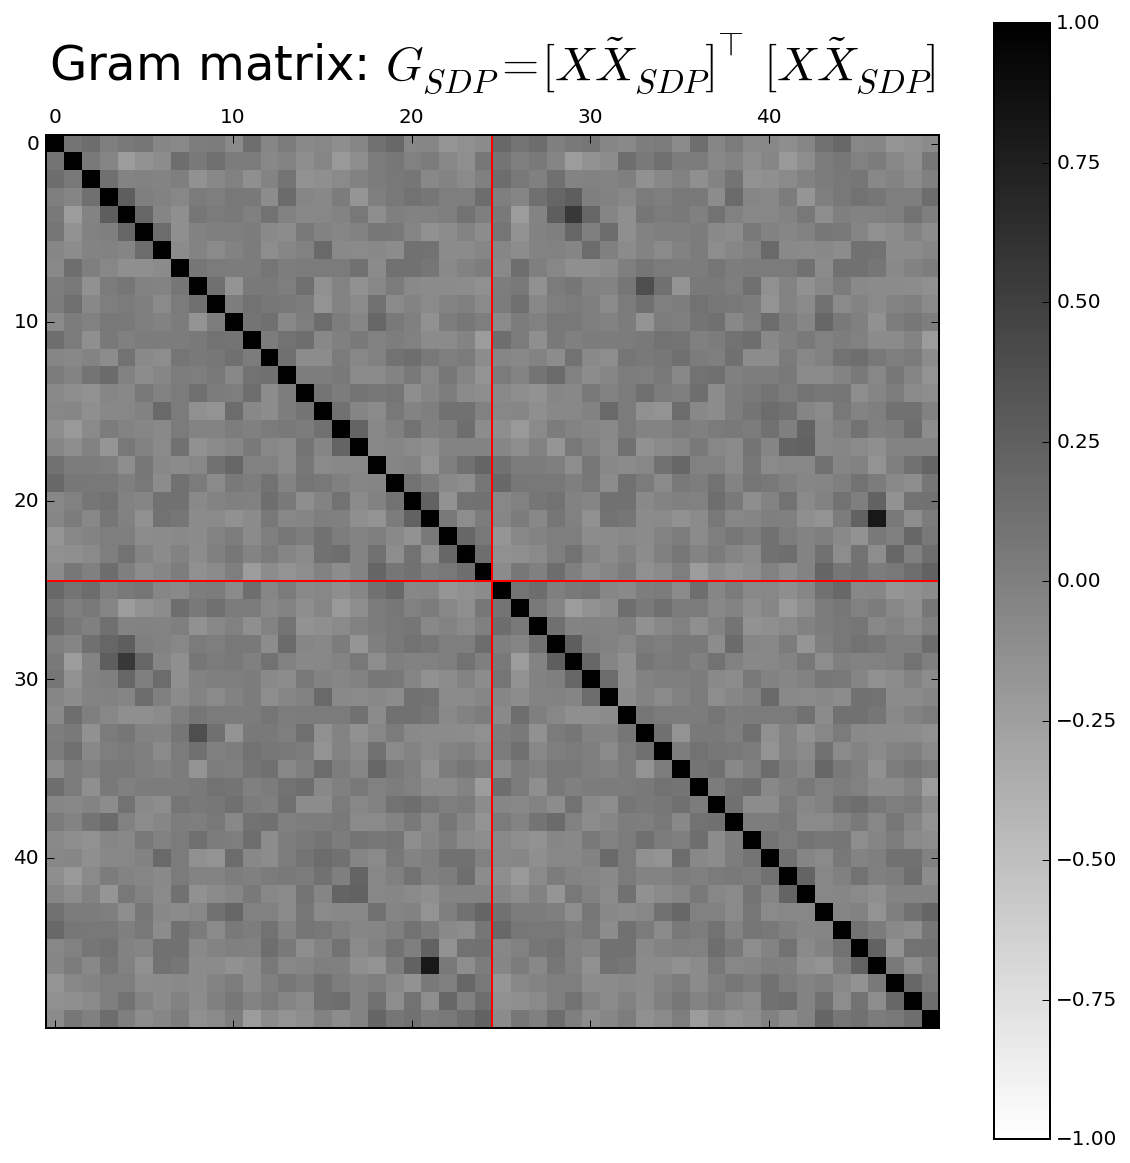

In [40]:
matshow_symm(sG1); colorbar(); 
title(r"Gram matrix: $G_{SDP} = [X \~X_{SDP}]^\top [X \~X_{SDP}]$")
gcf().set_size_inches(10,10)
hlines(p-0.5, -0.5, 2*p-0.5, colors='r'); vlines(p-0.5, -0.5, 2*p-0.5, colors='r');

# Regression


In [673]:
import sklearn.linear_model

In [730]:
na = 5 * p
eps = 1e-8
alphas1, coefs1, gaps1 = sklearn.linear_model.lasso_path(np.hstack([X, X_ko1]), y, 
                                                           n_alphas=na, eps=eps)

alphas2, coefs2, gaps2 = sklearn.linear_model.lasso_path(np.hstack([X, X_ko2]), y, 
                                                           n_alphas=na, eps=eps)


/Users/huth/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:262: DeprecationWarning: fit_intercept param will be removed in 0.16. Intercept fitting and feature normalization will be done in estimators.
  return_models=return_models, **params)
/Users/huth/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:262: DeprecationWarning: fit_intercept param will be removed in 0.16. Intercept fitting and feature normalization will be done in estimators.
  return_models=return_models, **params)


In [731]:
print alphas1.shape, coefs1.shape, gaps1.shape

(125,) (50, 125) (125,)


In [745]:
sklearn.linear_model.lasso_path?

/Users/huth/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


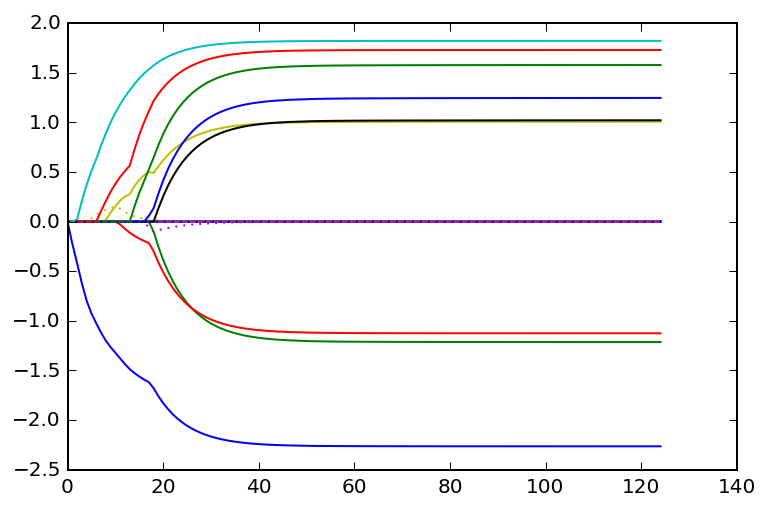

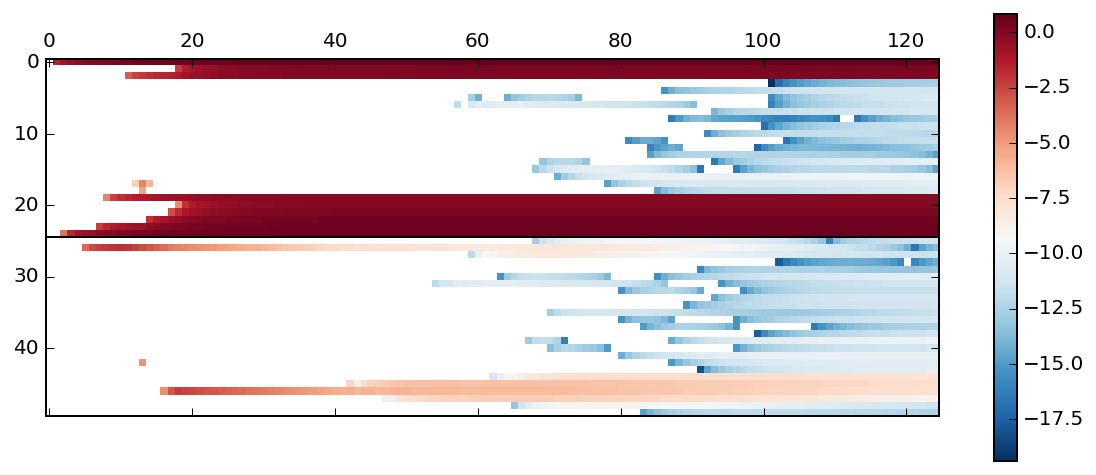

In [744]:
plot(coefs1[:p].T, '-');
plot(coefs2[p:].T, ':');

matshow(np.log(np.abs(coefs2)), cmap=cm.RdBu_r); colorbar();
hlines(p-0.5, -0.5, na-0.5)

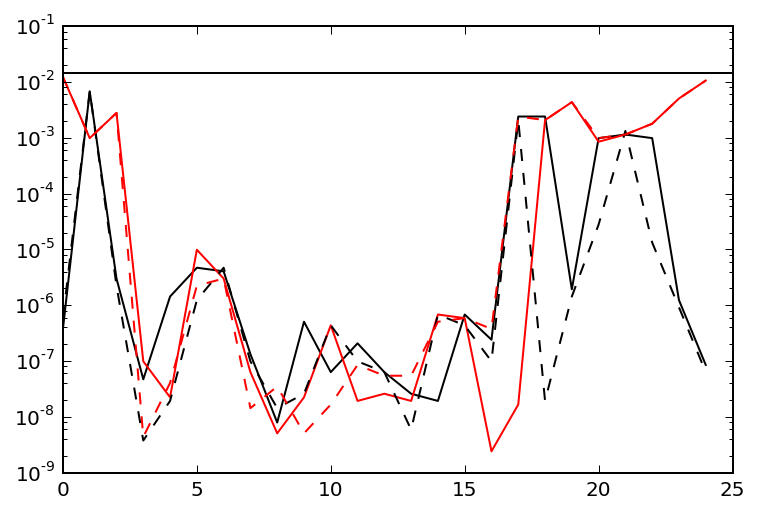

In [736]:
fnz1 = alphas1[np.array([np.nonzero(a)[0].min() for a in coefs1])]
fnz2 = alphas2[np.array([np.nonzero(a)[0].min() for a in coefs2])]

semilogy(fnz1[p:], 'k-')
semilogy(fnz1[:p], 'r-')

semilogy(fnz2[p:], 'k--')
semilogy(fnz2[:p], 'r--')

hlines(alphas1.max(), 0, p);

In [737]:
W1 = np.maximum(fnz1[:p], fnz1[p:]) * np.sign(fnz1[:p] - fnz1[p:])
W2 = np.maximum(fnz2[:p], fnz2[p:]) * np.sign(fnz2[:p] - fnz2[p:])

(-8.4252394071374095,
 -1.9091103748793454,
 -8.4252394071374095,
 -1.9091103748793454)

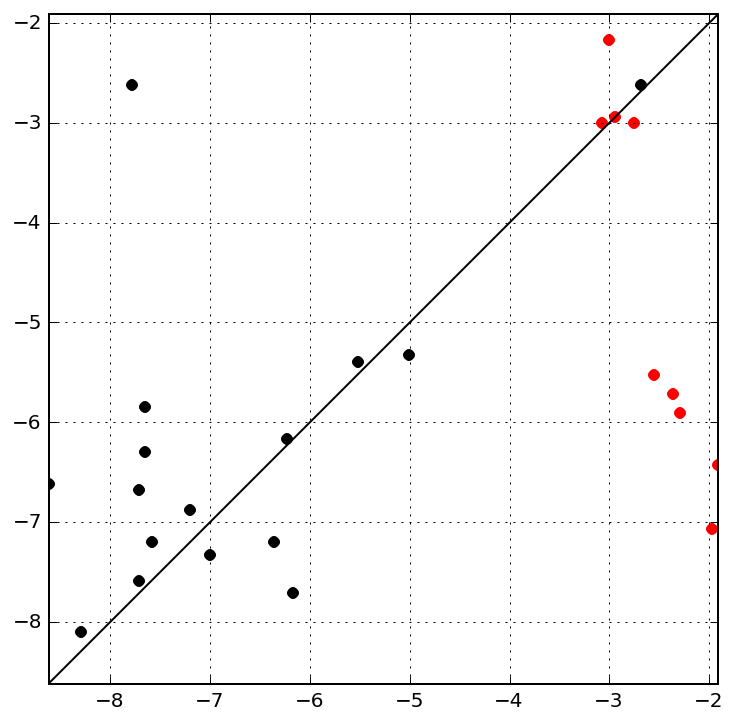

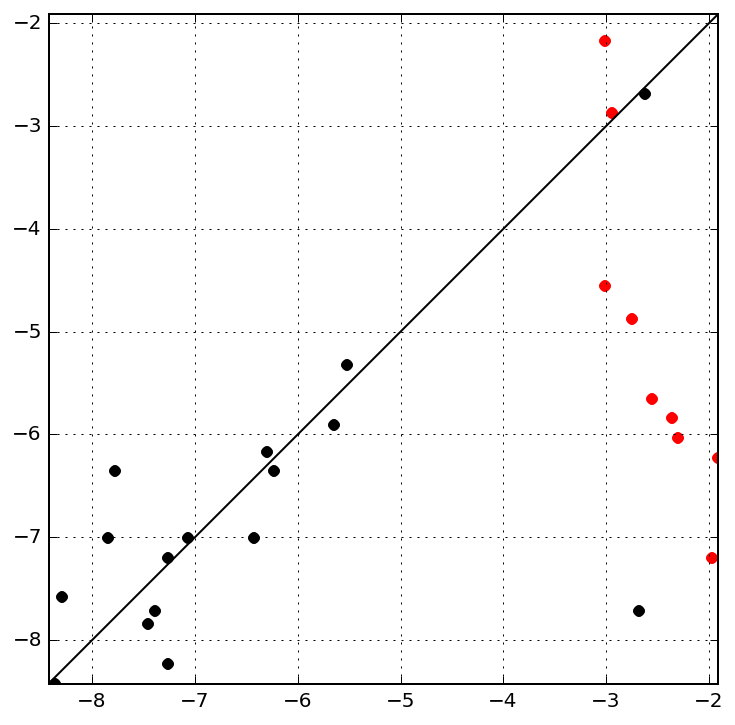

In [765]:
figure(figsize=(6,6))
nz_beta = beta != 0
plot(np.log10(fnz1[:p][nz_beta]), np.log10(fnz1[p:][nz_beta]), 'ro', mec='none')
plot(np.log10(fnz1[:p][~nz_beta]), np.log10(fnz1[p:][~nz_beta]), 'ko', mec='none')
mi, ma = np.log10(fnz1).min(), np.log10(fnz1).max()
plot([mi, ma], [mi, ma], 'k-')
grid(); axis("tight")

figure(figsize=(6,6))
nz_beta = beta != 0
plot(np.log10(fnz2[:p][nz_beta]), np.log10(fnz2[p:][nz_beta]), 'ro', mec='none')
plot(np.log10(fnz2[:p][~nz_beta]), np.log10(fnz2[p:][~nz_beta]), 'ko', mec='none')
mi, ma = np.log10(fnz2).min(), np.log10(fnz2).max()
plot([mi, ma], [mi, ma], 'k-')
grid(); axis("tight")